#Bài toán 2: dự đoán khả năng mở rộng bơ conventional tại GreatLakes

In [ ]:
#Note: đối với bài toán time series, dữ liệu phải liên tục
#---> không loại outlier. Không xóa dòng.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS0_k271_HoangDucHuy/Project_01_price_prediction_and_time_series/Re_do'

/content/gdrive/My Drive/LDS0_k271_HoangDucHuy/Project_01_price_prediction_and_time_series/Re_do


###Chuẩn bị data

In [ ]:
#lấy data từ đầu, không lấy data đã qua xử lý

In [ ]:
%%capture
!pip install fbprophet
!pip install pmdarima
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [ ]:
data = pd.read_csv('avocado.csv', index_col = 0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


In [ ]:
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


#Bài toán: chọn vùng bơ HASS đang kinh doanh trong tương lai có thể mở rộng sản xuất, trồng trọt và kinh doanh

In [ ]:
#tạo thêm cột revenue = AveragePrice * Total Volume, chuyển sang dơn vị triệu

In [ ]:
dr = data.copy()
import datetime
dr['revenue'] = dr['AveragePrice'] * dr['Total Volume']/1000000 
dr['Date'] =  pd.to_datetime(dr['Date'])
dr = dr.set_index('Date')
dr.head(5)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,revenue
Date,,,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,0.085435
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,0.074084
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,0.109945
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,0.085312
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,0.065331


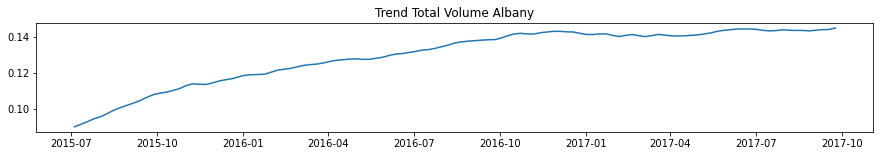

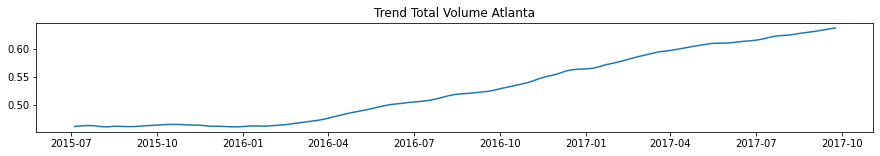

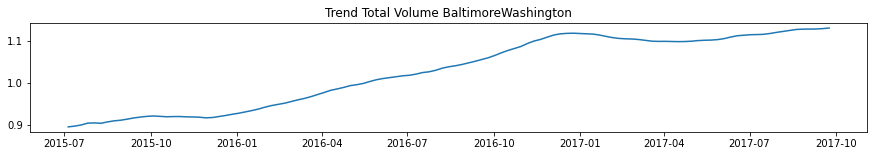

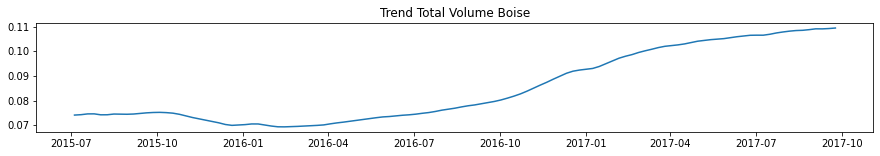

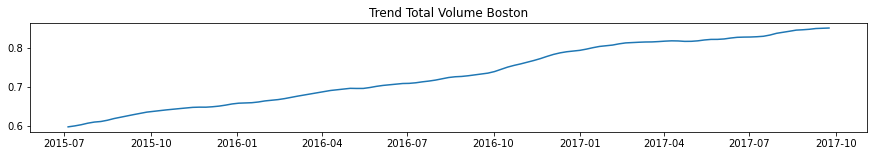

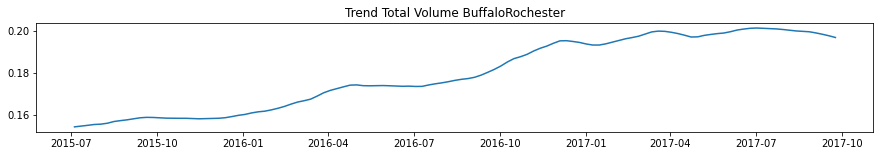

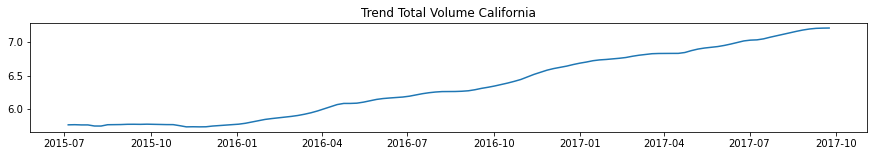

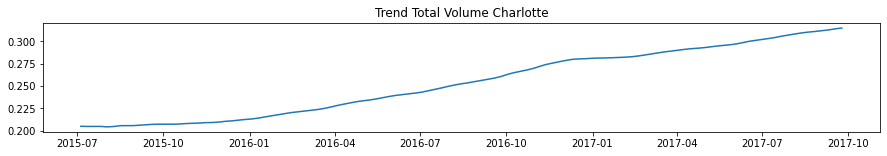

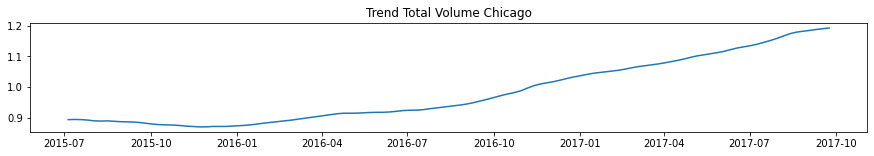

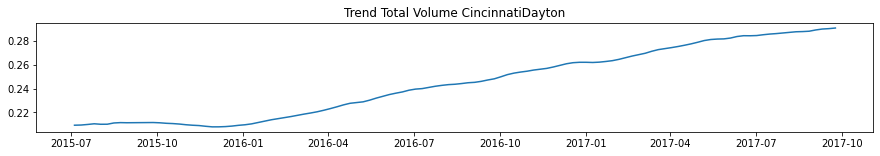

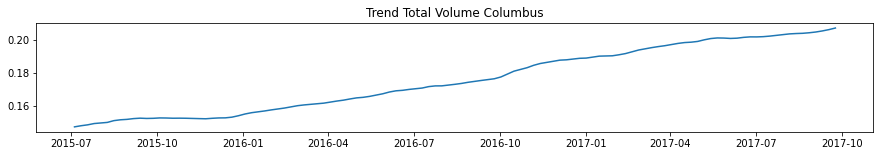

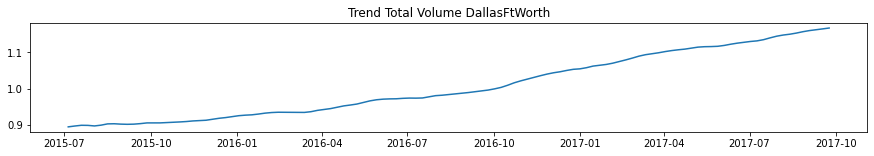

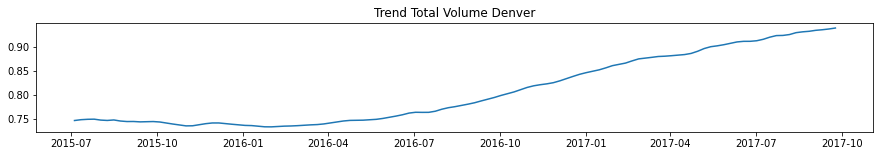

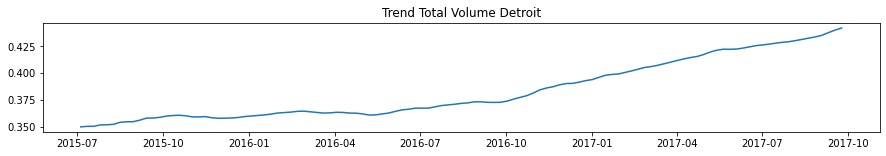

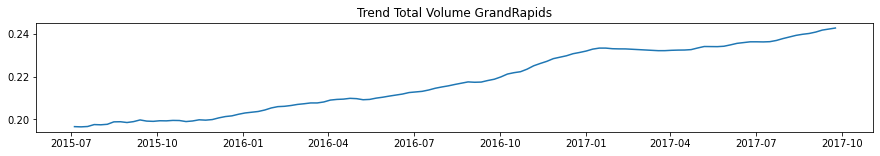

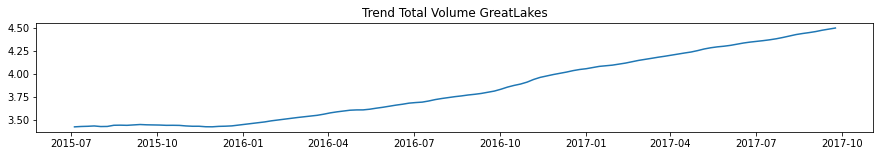

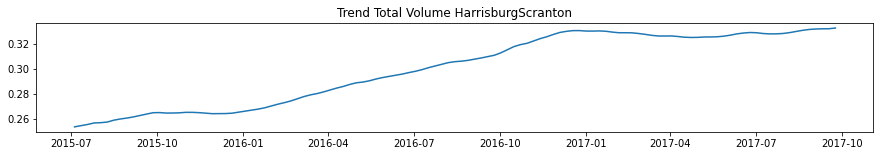

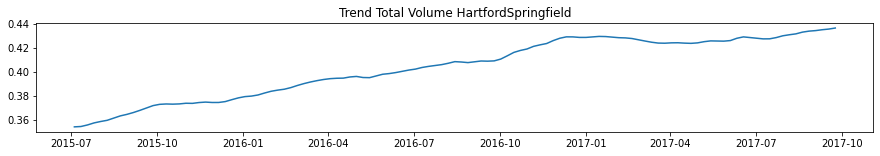

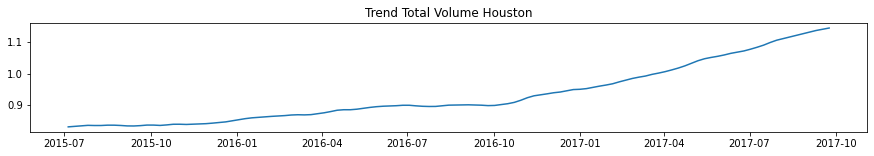

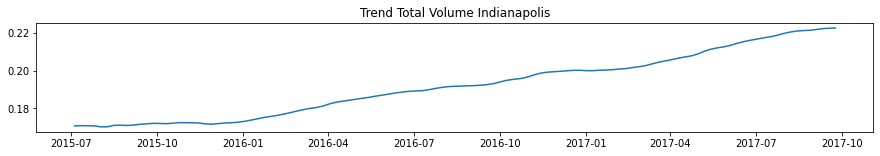

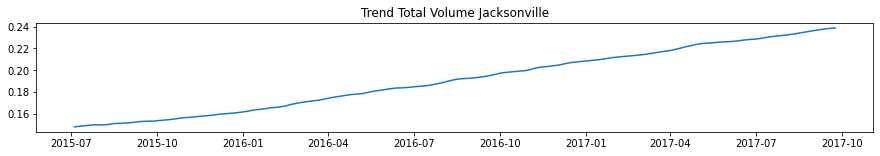

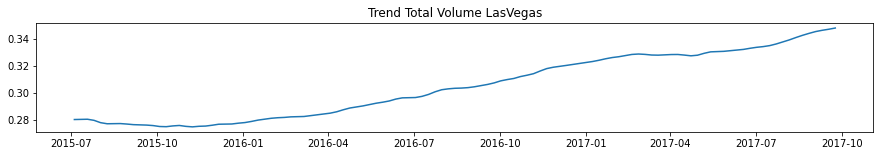

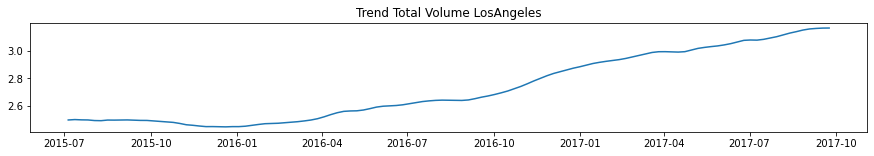

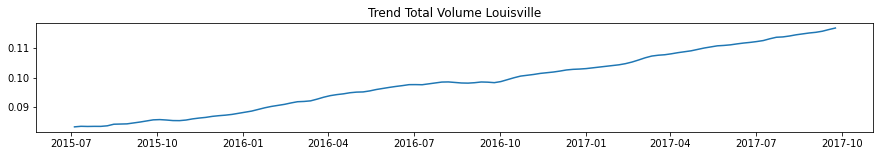

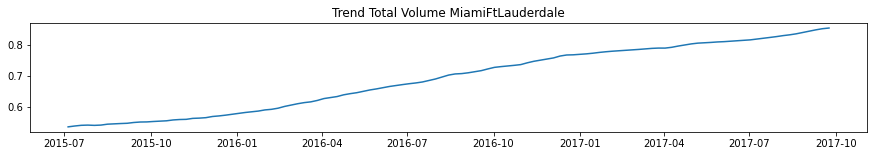

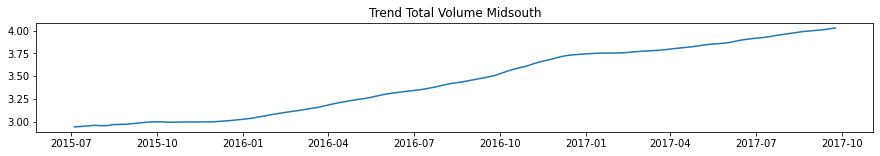

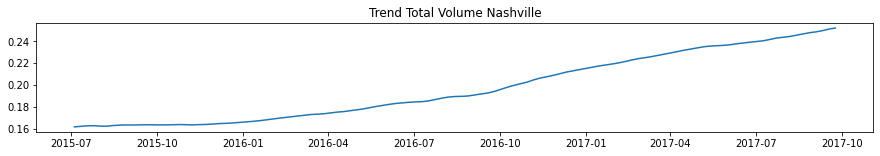

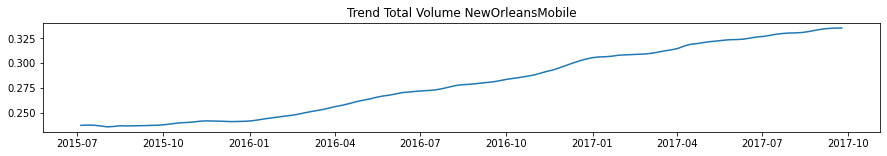

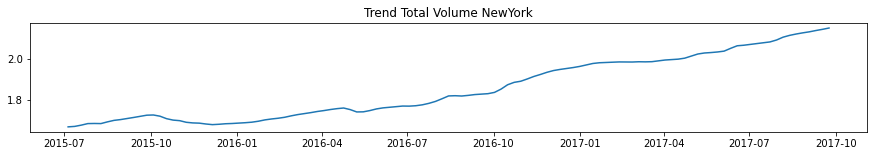

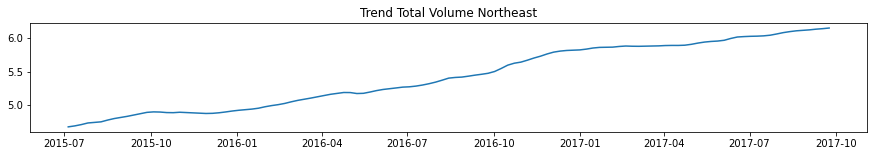

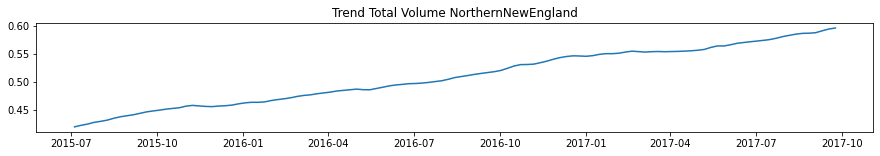

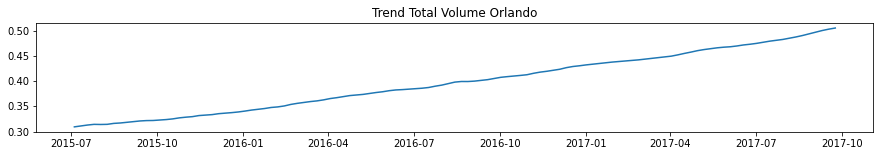

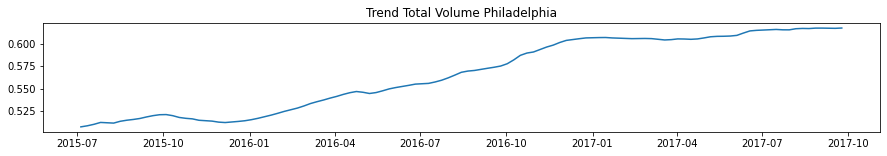

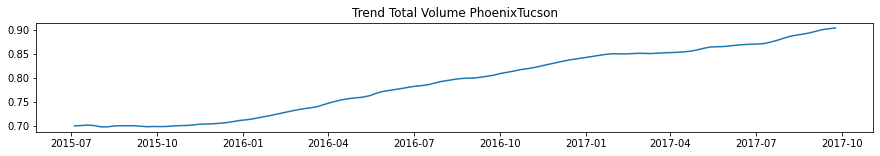

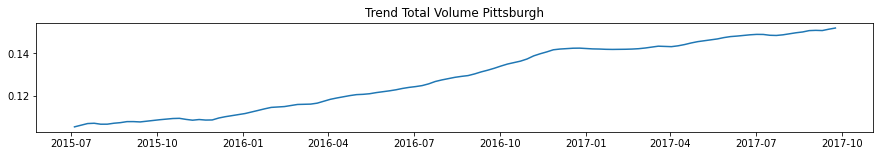

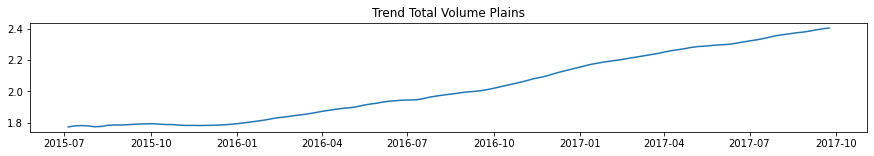

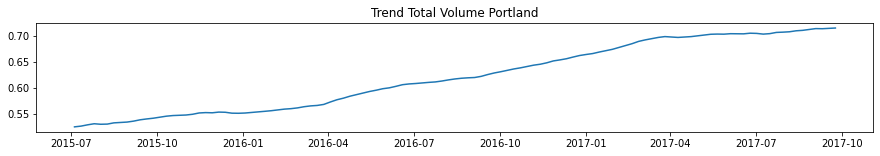

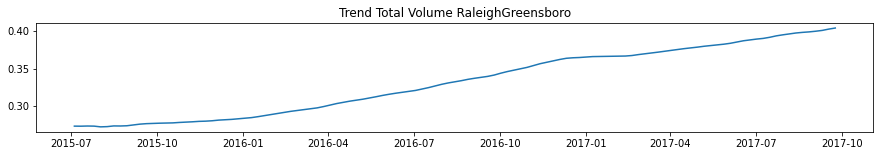

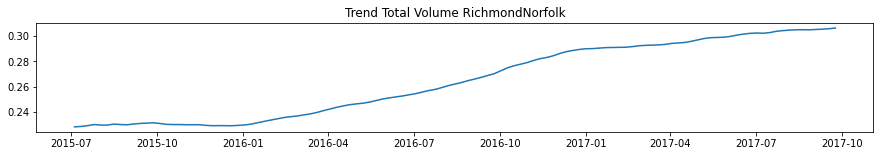

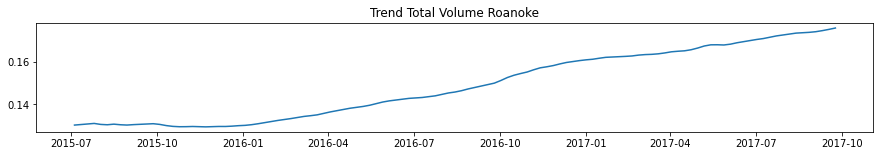

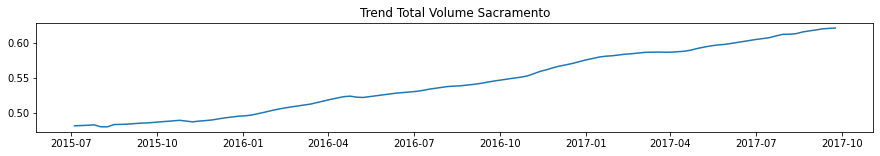

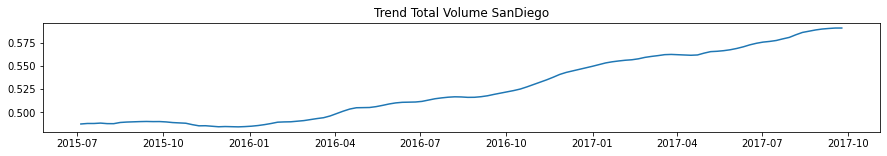

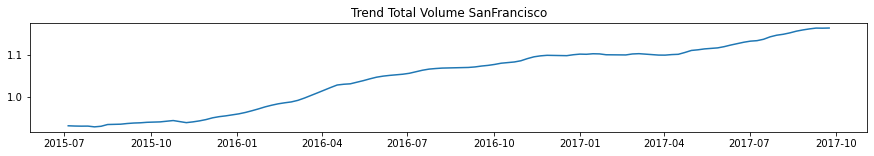

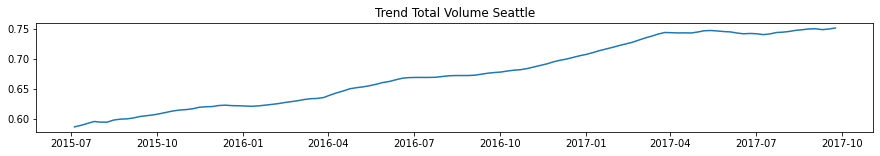

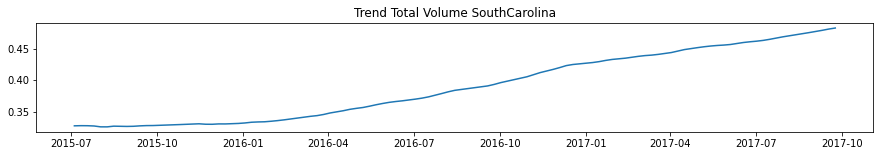

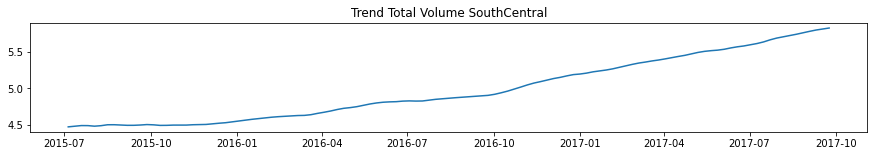

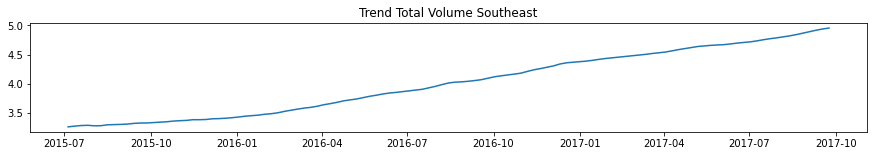

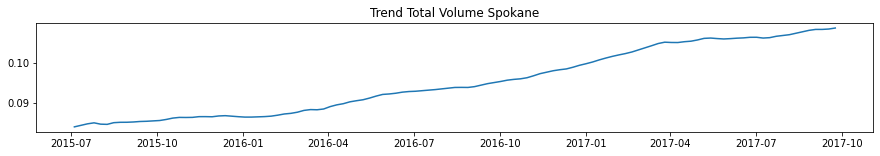

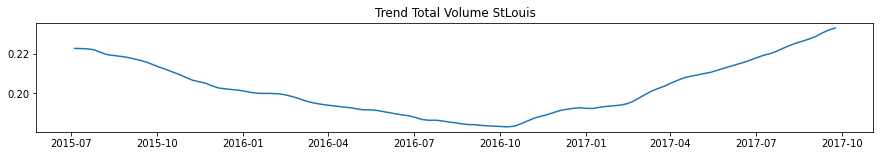

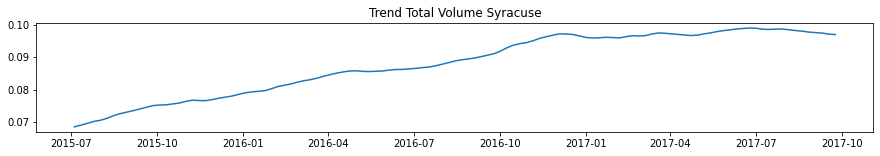

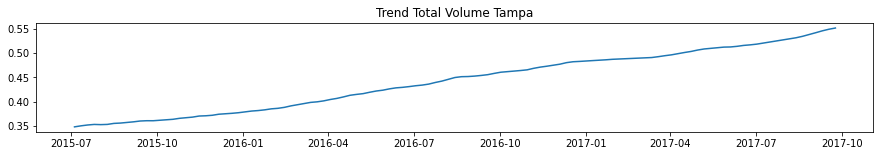

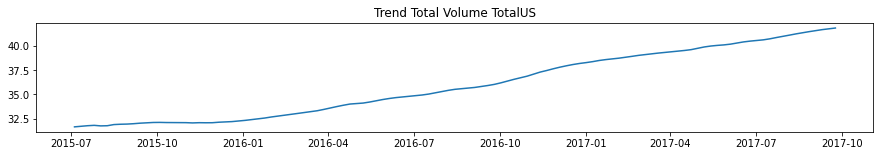

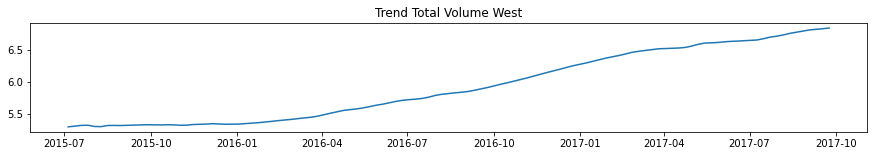

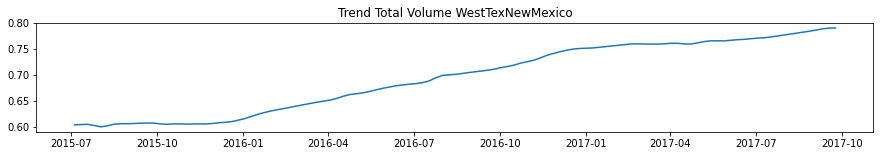

In [ ]:
for i in dr['region'].unique().tolist():
  dr_revenue = dr[(dr['type'] == 'conventional') & (dr['region']==i)][['revenue']].sort_index()
  revenue = seasonal_decompose(dr_revenue['revenue'], model='multiplicative')
  plt.figure(figsize=(15, 2))
  plt.plot(revenue.trend)
  plt.title('Trend Total Volume ' + i)
  plt.show()

Nhận xét: dựa vào phân tích xu hướng theo value (AveragePrice * Total Volume), ta có thể chọn vùng GreatLakes do có value lớn (max value ~ 4.5 triệu USD) và có xu hướng tăng mạnh mẽ theo thời gian 

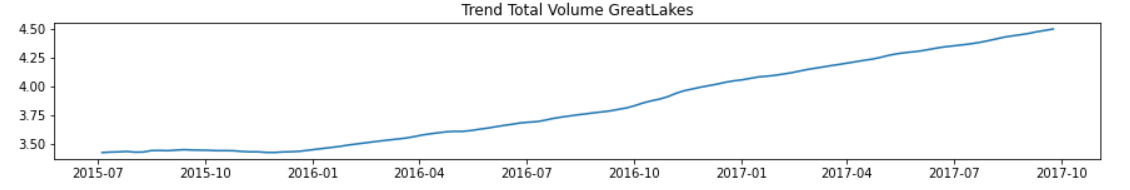

#Áp dụng các thuật toán để dự đoán giá bơ conventional tại GreatLakes

In [ ]:
#sử dụng các thuật toán như ARIMA, Prophet, Holt-Winter

In [ ]:
df = data[['Date', 'AveragePrice', 'type', 'region']]

In [ ]:
#lọc lấy region = GreatLakes và type =  conventional
df = df[df['region'] == 'GreatLakes']
df = df[df['type'] == 'conventional']

In [ ]:
df.head()

,Date,AveragePrice,type,region
0,2015-12-27,1.01,conventional,GreatLakes
1,2015-12-20,1.01,conventional,GreatLakes
2,2015-12-13,1.03,conventional,GreatLakes
3,2015-12-06,1.00,conventional,GreatLakes
4,2015-11-29,1.07,conventional,GreatLakes


In [ ]:
#chuyển cột Date sang dạng datetime
df['Date']= pd.to_datetime(df['Date'])

In [ ]:
#MS: Month Start, tính mean của các tháng theo month
df1 = df.resample('MS', on='Date').mean()

In [ ]:
df1.head()

,AveragePrice
Date,
2015-01-01,1.0825
2015-02-01,1.0725
2015-03-01,1.0580
2015-04-01,1.1225
2015-05-01,1.1280


In [ ]:
df1 = df1.rename_axis('Month').reset_index()
df1.head()

,Month,AveragePrice
0,2015-01-01,1.0825
1,2015-02-01,1.0725
2,2015-03-01,1.0580
3,2015-04-01,1.1225
4,2015-05-01,1.1280


In [ ]:
#đổi tên cá cột
df1.columns = ['ds','y']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      39 non-null     datetime64[ns]
 1   y       39 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 752.0 bytes


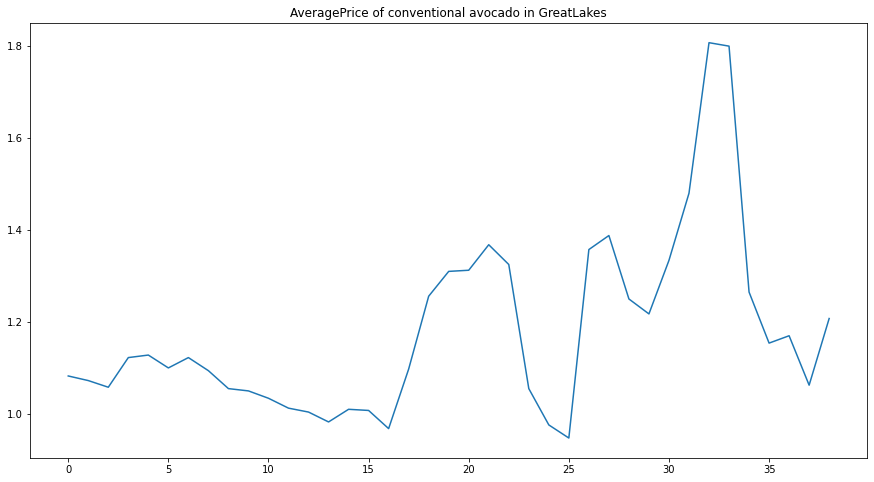

In [ ]:
# Trực quan hóa giá trung bình qua các tháng
plt.figure(figsize=(15,8))
plt.plot(df1.y)
plt.title('AveragePrice of conventional avocado in GreatLakes')
plt.show()

Nhận xét: giá trung bình có xu hướng tăng qua các thời kỳ

In [ ]:
#chia dữ liệu train/ test

In [ ]:
#có 39 tháng --> 30 tháng cho train, 9 tháng cho test

In [ ]:
#39 tháng cho train
train = df1.iloc[0:30]
train.tail()

,ds,y
25,2017-02-01,0.9475
26,2017-03-01,1.3575
27,2017-04-01,1.3880
28,2017-05-01,1.2500
29,2017-06-01,1.2175


In [ ]:
#9 tháng cho test
test = df1.iloc[30:]
test.tail()

,ds,y
34,2017-11-01,1.2650
35,2017-12-01,1.1540
36,2018-01-01,1.1700
37,2018-02-01,1.0625
38,2018-03-01,1.2075


In [ ]:
test.head()

,ds,y
30,2017-07-01,1.3340
31,2017-08-01,1.4800
32,2017-09-01,1.8075
33,2017-10-01,1.8000
34,2017-11-01,1.2650


###Bước 4&5: Modeling & Evaluation/ Analyze & Report

#Build model - Prophet

In [ ]:
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(train) #fit train --> 30 tháng

INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [ ]:
#9 month in test and 12 month to preidct new value
#test bắt đầu từ 2017-07-01, kết thúc 2018-03-01
#predict thêm 1 năm ==> kết thúc 2019-03-01
#model sẽ predict thời gian từ 9 tháng của test cộng thêm 12 tháng mới
months = pd.date_range('2017-07-01','2019-03-01',freq='MS').strftime("%Y-%m-%d").tolist()
future = pd.DataFrame(months)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [ ]:
#use model to make forcast
forecast = model.predict(future) 

In [ ]:
forecast[['ds', 'yhat']].head()

,ds,yhat
0,2017-07-01,1.313830
1,2017-08-01,1.327860
2,2017-09-01,1.308325
3,2017-10-01,1.343736
4,2017-11-01,1.316899


In [ ]:
forecast[['ds', 'yhat']].tail()

,ds,yhat
16,2018-11-01,1.375273
17,2018-12-01,1.257894
18,2019-01-01,1.283137
19,2019-02-01,1.252989
20,2019-03-01,1.319706


#Evaluate

In [ ]:
df1['y'].mean()

1.1806282051282049

In [ ]:
test['y'].mean()

1.3644999999999998

In [ ]:
#tính toán MAE/RMSE giữa giá trị thực tế (y_test) và giá trị dự đoán (y_pred)

In [ ]:
y_test = test['y'].values #giá trị thực (9 giá trị)
y_pred = forecast['yhat'].values[:9] #9 giá trị đầu tiên
mae_p = mean_absolute_error(y_test,y_pred)
print('MAE: %.3f' %mae_p)

MAE: 0.152


In [ ]:
rmse_p = sqrt(mean_squared_error(y_test,y_pred))
print('RMSE: %.3f' %rmse_p)

RMSE: 0.236


Nhận xét:
- mean(test) ~ 1.36, mae ~ 0.15 --> mean(mae)/mean(test) ~ 11 %
- mean của toàn data (df1.y) ~ 1.18, mae ~ 0.15 --> mean(mae)/mean(toàn data) ~ 12.8 %
==> sai lệch nhỏ, có thể chấp nhận

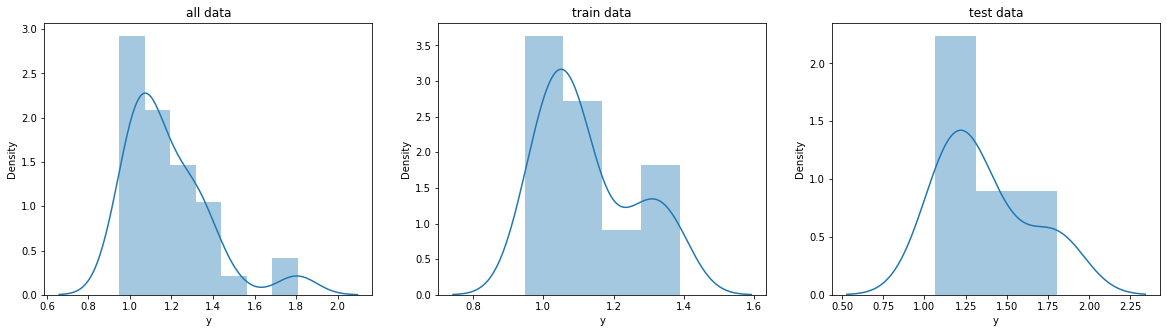

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['y'])
plt.title('all data')
plt.subplot(1,3,2)
sns.distplot(train['y'])
plt.title('train data')
plt.subplot(1,3,3)
sns.distplot(test['y'])
plt.title('test data')
plt.show()

In [ ]:
y_test 

array([1.334 , 1.48  , 1.8075, 1.8   , 1.265 , 1.154 , 1.17  , 1.0625,
       1.2075])

In [ ]:
y_pred 

array([1.31382954, 1.32785967, 1.30832479, 1.34373629, 1.31689888,
       1.14359325, 1.16436794, 1.16699447, 1.2793204 ])

In [ ]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']),columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']),columns=['Prediction'])

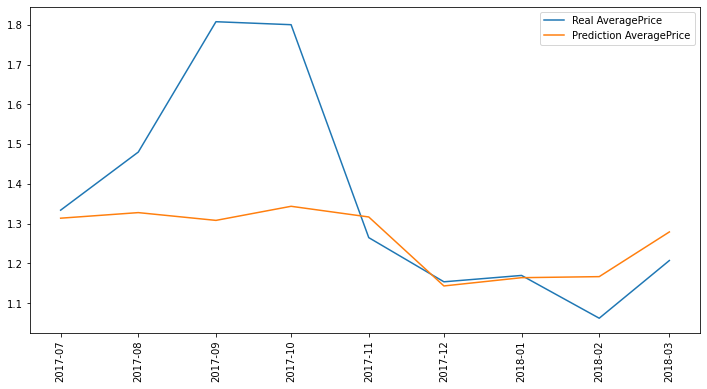

In [ ]:
# Visulaize the result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='Real AveragePrice')
plt.plot(y_pred_value, label='Prediction AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Nhận xét: prediction và real value có sự chênh lệch chấp nhận được (~ 15% giá trị mean) nên mức dự đoán có thể chấp nhận được

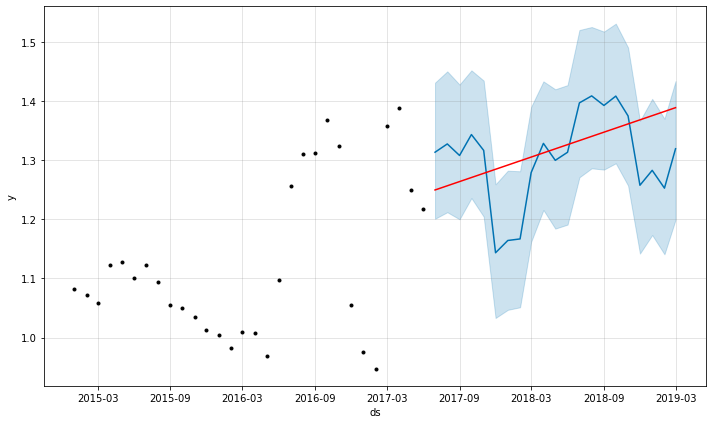

In [ ]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(),model,forecast)

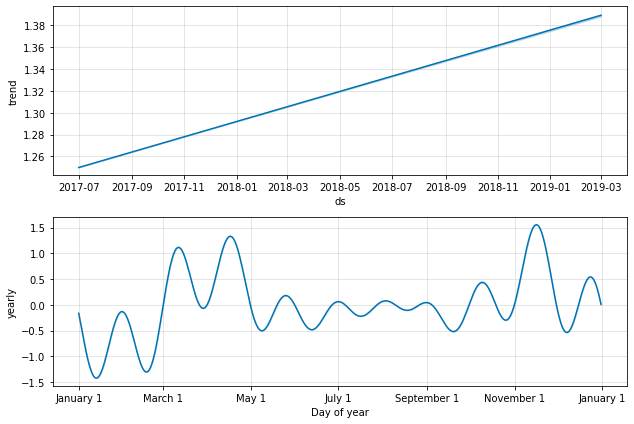

In [ ]:
fig1 = model.plot_components(forecast)
fig1.show()

Nhận xét: xu hướng là tăng cho đến tháng 03/2019

#Dự đoán cho 12 tháng kế tiếp

In [ ]:
forecast[['ds','yhat']].tail(12)

,ds,yhat
9,2018-04-01,1.328801
10,2018-05-01,1.300085
11,2018-06-01,1.313750
12,2018-07-01,1.397402
13,2018-08-01,1.409212
14,2018-09-01,1.393006
15,2018-10-01,1.408864
16,2018-11-01,1.375273
17,2018-12-01,1.257894
18,2019-01-01,1.283137


#Dự đoán cho 5 năm tiếp theo, chúng ta có thể mở rộng kinh doanh?

In [ ]:
m = Prophet(yearly_seasonality=True, daily_seasonality=False,weekly_seasonality=False)
m.fit(df1) #fit df1 (dùng df1 để train) --> 39 tháng --> dự đoán tiếp 5  năm sau df1
future = m.make_future_dataframe(periods = 12*5,freq='M') # next 5 years

In [ ]:
forecast = m.predict(future)

In [ ]:
forecast.shape #39 tháng (train) + 60 tháng

(99, 16)

In [ ]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          99 non-null     datetime64[ns]
 1   trend                       99 non-null     float64       
 2   yhat_lower                  99 non-null     float64       
 3   yhat_upper                  99 non-null     float64       
 4   trend_lower                 99 non-null     float64       
 5   trend_upper                 99 non-null     float64       
 6   additive_terms              99 non-null     float64       
 7   additive_terms_lower        99 non-null     float64       
 8   additive_terms_upper        99 non-null     float64       
 9   yearly                      99 non-null     float64       
 10  yearly_lower                99 non-null     float64       
 11  yearly_upper                99 non-null     float64       
 

In [ ]:
forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
87,2022-03-31,1.757678,1.596117,1.912578,1.829077,1.827772,1.830327
88,2022-04-30,1.915048,1.759794,2.067822,1.838080,1.836739,1.839374
89,2022-05-31,1.888721,1.736021,2.029190,1.847382,1.846025,1.848719
90,2022-06-30,1.941718,1.798644,2.081986,1.856384,1.854982,1.857769
91,2022-07-31,1.962539,1.808915,2.104421,1.865687,1.864249,1.867118
92,2022-08-31,1.964857,1.814221,2.115338,1.874989,1.873536,1.876468
93,2022-09-30,1.899259,1.742145,2.057702,1.883992,1.882487,1.885508
94,2022-10-31,1.828955,1.670865,1.985334,1.893294,1.891726,1.894858
95,2022-11-30,1.907409,1.756119,2.062907,1.902297,1.900671,1.903895
96,2022-12-31,1.944862,1.795015,2.099550,1.911599,1.909933,1.913238


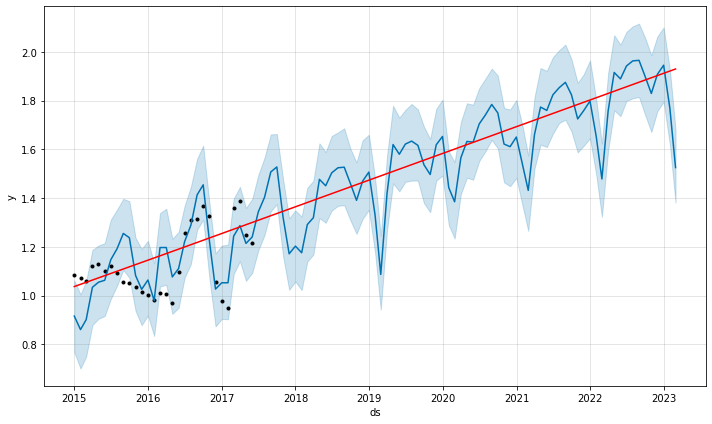

In [ ]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(),m,forecast)

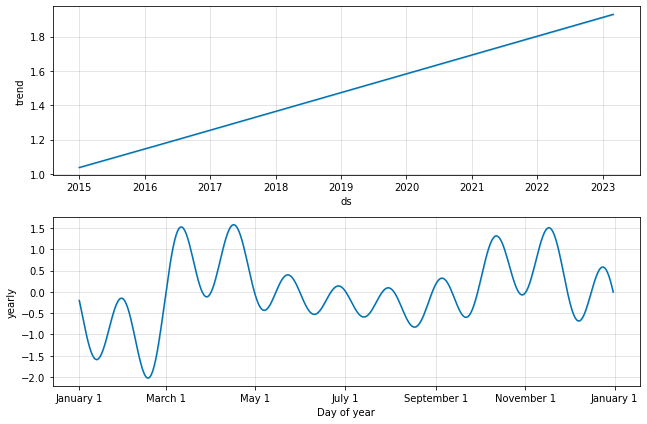

In [ ]:
fig1 = m.plot_components(forecast)
fig1.show()

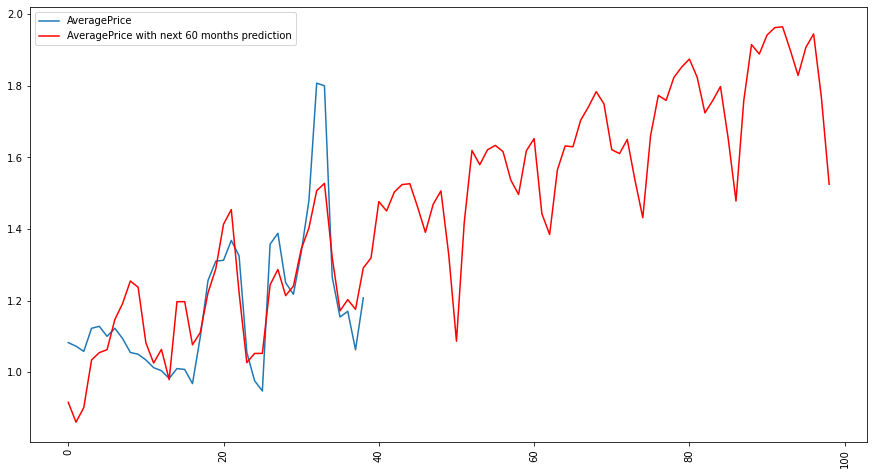

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(df1['y'],label='AveragePrice')
plt.plot(forecast['yhat'],label='AveragePrice with next 60 months prediction',color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

<font color='blue'>- Từ biểu đồ cho thấy, xu hướng tăng trưởng của 5 năm tiếp theo có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này</font>

#Build model - ARIMA

In [ ]:
from pmdarima import auto_arima 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 11
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          169 non-null    datetime64[ns]
 1   AveragePrice  169 non-null    float64       
 2   type          169 non-null    object        
 3   region        169 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.6+ KB


In [ ]:
df2 = df.resample('MS', on='Date').mean()

In [ ]:
df2.head()

,AveragePrice
Date,
2015-01-01,1.0825
2015-02-01,1.0725
2015-03-01,1.0580
2015-04-01,1.1225
2015-05-01,1.1280


In [ ]:
stepwise_model = auto_arima(df2, start_p=2, start_q=2,
                           max_p=5, max_q=5, m=12,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-15.140, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-12.562, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-13.537, Time=0.18 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-14.267, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-14.394, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-13.361, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-14.077, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-13.147, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.134 seconds


In [ ]:
print(stepwise_model.aic())

-15.140156426387904


In [ ]:
# Train & test: train  30 months, test 9 months
train = df2.iloc[:-9,:]
test = df2.iloc[-9:,:]

In [ ]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
future_forecast = stepwise_model.predict(n_periods=len(test))
future_forecast

array([1.376 , 1.43  , 1.4325, 1.488 , 1.445 , 1.175 , 1.096 , 1.0675,
       1.4775])

In [ ]:
future_forecast = pd.DataFrame(future_forecast,columns=['Prediction'],index=test.index)
future_forecast

,Prediction
Date,
2017-07-01,1.3760
2017-08-01,1.4300
2017-09-01,1.4325
2017-10-01,1.4880
2017-11-01,1.4450
2017-12-01,1.1750
2018-01-01,1.0960
2018-02-01,1.0675
2018-03-01,1.4775


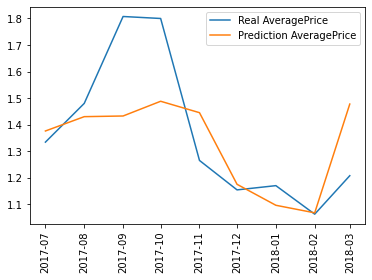

In [ ]:
plt.plot(test,label='Real AveragePrice')
plt.plot(future_forecast,label='Prediction AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

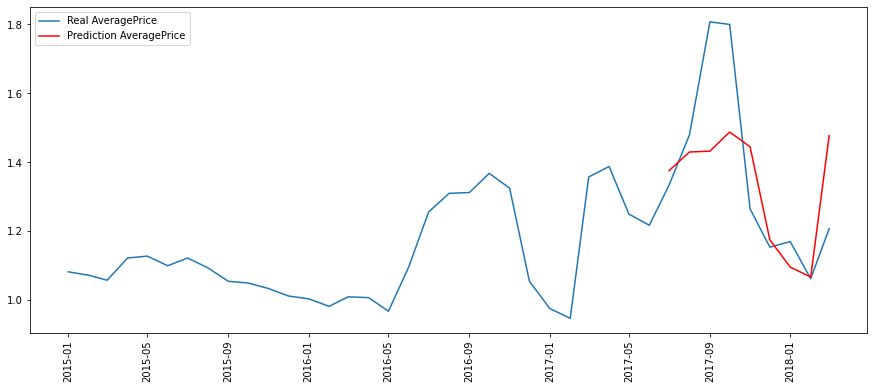

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df2,label='Real AveragePrice')
plt.plot(future_forecast,label='Prediction AveragePrice',color='r')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Nhận xét: giá prediction và real có sự chênh lệch

#Evaluation

In [ ]:
df2['AveragePrice'].mean()

1.1806282051282049

In [ ]:
test['AveragePrice'].mean()

1.3644999999999998

In [ ]:
mae = mean_absolute_error(test, future_forecast[0:len(test)])
mae

0.14766666649788204

In [ ]:
mse = mean_squared_error(test, future_forecast[0:len(test)])
mse

0.03927500010393553

- Mean test = 1.36, mae & mse ~ 11% of mean test
- Mean all data = 1.18, mae & mse ~ 12.5% of mean data
- Chênh lệch nhỏ => chấp nhận được

Dự báo cho 12 tháng tiếp theo 

In [ ]:
future_forecast_12_month = stepwise_model.predict(n_periods=len(test)+12)
future_forecast_12_month

array([1.376 , 1.43  , 1.4325, 1.488 , 1.445 , 1.175 , 1.096 , 1.0675,
       1.4775, 1.508 , 1.37  , 1.3375, 1.496 , 1.55  , 1.5525, 1.608 ,
       1.565 , 1.295 , 1.216 , 1.1875, 1.5975])

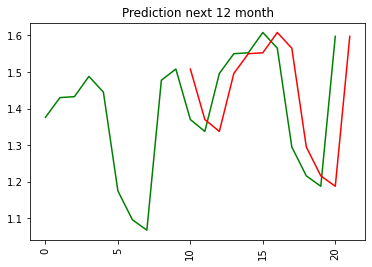

In [ ]:
plt.plot(np.arange(21),future_forecast_12_month,color='g')
plt.plot(np.arange(10,22,1),future_forecast_12_month[len(test):],color='r')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 month')
plt.show()

Dự báo cho 5 năm tiếp theo

In [ ]:
future_forecast_60_month = stepwise_model.predict(n_periods=len(test)+60)
future_forecast_60_month

array([1.376     , 1.43      , 1.4325    , 1.488     , 1.445     ,
       1.175     , 1.096     , 1.0675    , 1.4775    , 1.508     ,
       1.37      , 1.3375    , 1.496     , 1.55      , 1.5525    ,
       1.608     , 1.565     , 1.295     , 1.216     , 1.1875    ,
       1.5975    , 1.628     , 1.49      , 1.4575    , 1.616     ,
       1.67      , 1.6725    , 1.728     , 1.685     , 1.415     ,
       1.336     , 1.3075    , 1.7175    , 1.748     , 1.61      ,
       1.5775    , 1.73599999, 1.78999999, 1.79249999, 1.84799999,
       1.80499999, 1.53499999, 1.45599999, 1.42749999, 1.83749999,
       1.86799999, 1.72999999, 1.69749999, 1.85599999, 1.90999999,
       1.91249999, 1.96799999, 1.92499999, 1.65499999, 1.57599999,
       1.54749999, 1.95749999, 1.98799999, 1.84999999, 1.81749999,
       1.97599999, 2.02999999, 2.03249999, 2.08799999, 2.04499999,
       1.77499999, 1.69599999, 1.66749999, 2.07749999])

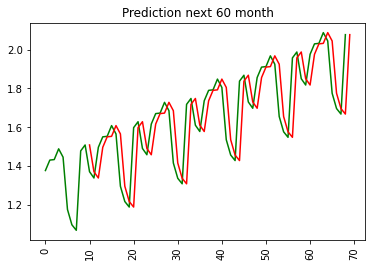

In [ ]:
plt.plot(np.arange(69),future_forecast_60_month,color='g')
plt.plot(np.arange(10,70,1),future_forecast_60_month[len(test):],color='r')
plt.xticks(rotation='vertical')
plt.title('Prediction next 60 month')
plt.show()

<font color='blue'>- Từ biểu đồ cho thấy, xu hướng tăng trưởng của 5 năm tiếp theo có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này</font>

#Holt-Winters

In [ ]:
model = ExponentialSmoothing(train,seasonal='mul',seasonal_periods=12).fit()
pred = model.predict(start=test.index[0],end=test.index[-1])

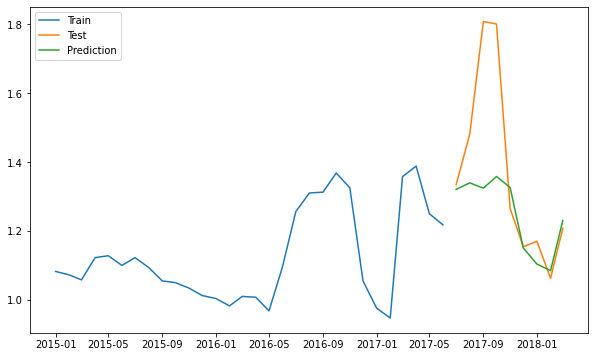

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.legend(loc='best')
plt.show()

#Evaluate

In [ ]:
df2['AveragePrice'].mean()

1.1806282051282049

In [ ]:
test['AveragePrice'].mean()

1.3644999999999998

In [ ]:
y_test = test['AveragePrice'].values
y_pred = pred.values
mae = mean_absolute_error(y_test, y_pred)
mae

0.1394840799020909

In [ ]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.22566536508545

- Mean test = 1.36, mae & mse ~ 10% of mean test
- Mean all data = 1.685, mae & mse ~ 12% of mean data
- Chênh lệch nhỏ => chấp nhận được

Dự báo cho 12 tháng tiếp theo 

In [ ]:
import datetime
start = datetime.datetime(2018,4,1)
end = datetime.datetime(2019,3,1)
pred_next_12_month = model.predict(start=start,end=end)
pred_next_12_month

2018-04-01    1.264969
2018-05-01    1.198903
2018-06-01    1.217500
2018-07-01    1.320287
2018-08-01    1.339490
2018-09-01    1.323926
2018-10-01    1.357896
2018-11-01    1.325875
2018-12-01    1.150380
2019-01-01    1.103917
2019-02-01    1.084608
2019-03-01    1.230269
Freq: MS, dtype: float64

In [ ]:
x = pd.Series(pred_next_12_month)
type(x)

pandas.core.series.Series

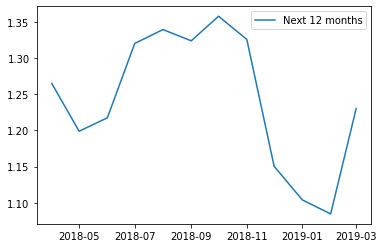

In [ ]:
plt.plot(x.index,x,label='Next 12 months')
plt.legend(loc='best')

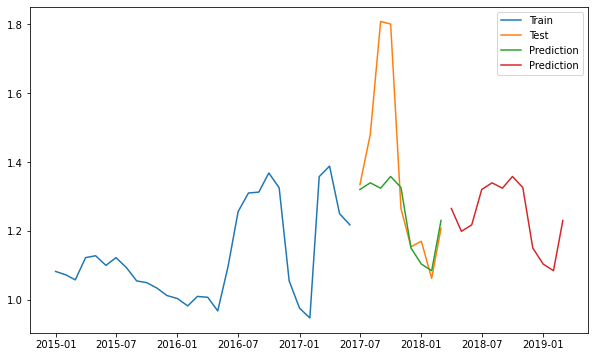

In [ ]:
# Truc quan hoa 
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.plot(pred_next_12_month.index,pred_next_12_month,label='Prediction')
plt.legend(loc='best')
plt.show()

Dự báo cho 60 tháng tiếp theo 

In [ ]:
import datetime
start = datetime.datetime(2018,4,1)
end = datetime.datetime(2023,3,1)
pred_next_60_month = model.predict(start=start,end=end)
pred_next_60_month[:10]

2018-04-01    1.264969
2018-05-01    1.198903
2018-06-01    1.217500
2018-07-01    1.320287
2018-08-01    1.339490
2018-09-01    1.323926
2018-10-01    1.357896
2018-11-01    1.325875
2018-12-01    1.150380
2019-01-01    1.103917
Freq: MS, dtype: float64

In [ ]:
x = pd.Series(pred_next_60_month)
type(x)

pandas.core.series.Series

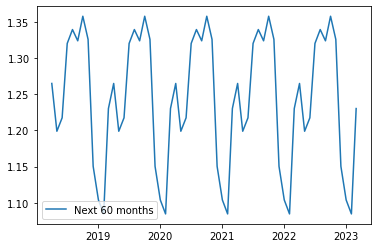

In [ ]:
plt.plot(x.index,x,label='Next 60 months')
plt.legend(loc='best')

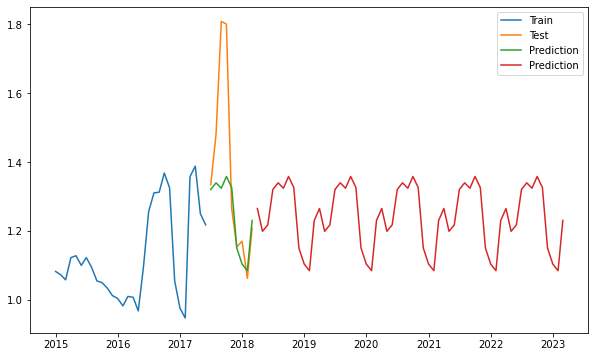

In [ ]:
# Trực quan hóa
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.plot(pred_next_60_month.index,pred_next_60_month,label='Prediction')
plt.legend(loc='best')
plt.show()

<font color ='blue'> - Xu hướng tăng trưởng 5 năm tiếp theo biến động ổn định theo chu kỳ</font>

Tổng kết

###<font color='blue'>
- Qua phân tích các thuật toán Prophet, Arima, Holtwinters <br>
  <font color='blue'>
  + Prophet test data: mae & mse ~ 10%, all data: mae & mse ~ 10% => chênh lệch nhỏ chấp nhận được <br>
  + Arima test data: mae & mse ~ 14%, all data: mae & mse ~ 15% => chênh lệch lớn => không chọn thuật toán này <br>
  + Holtwinters test data: mae & mse ~ 10%, all data: mae & mse ~ 10% => chênh lệch nhỏ chấp nhận được</font>
- Dự báo xu hướng tăng trưởng từ 12 tháng đến 60 tháng tiếp theo của loại bơ conventional tại vùng GreatLakes, cả 3 thuật toán trên có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này 
</font>